In [1]:
import main
from main import StepResult, ElasticData, CalculationResult
import network
import matplotlib.pyplot as plt
import convert
import os

opt_dir = "/home/sergey/work/auxetic_optimizer/newest_try"

In [2]:
opt_history = main.load_optimization_log(os.path.join(opt_dir, "optimization_log.pkl"))

In [3]:
steps = [i+1 for i in range(len(opt_history))]
Bs = [step.dG.bulk_modulus for step in opt_history]
Gs = [step.dG.shear_modulus for step in opt_history]
Ps = [step.dG.p_ratio for step in opt_history]
Zs = [step.network.coordination_number for step in opt_history]

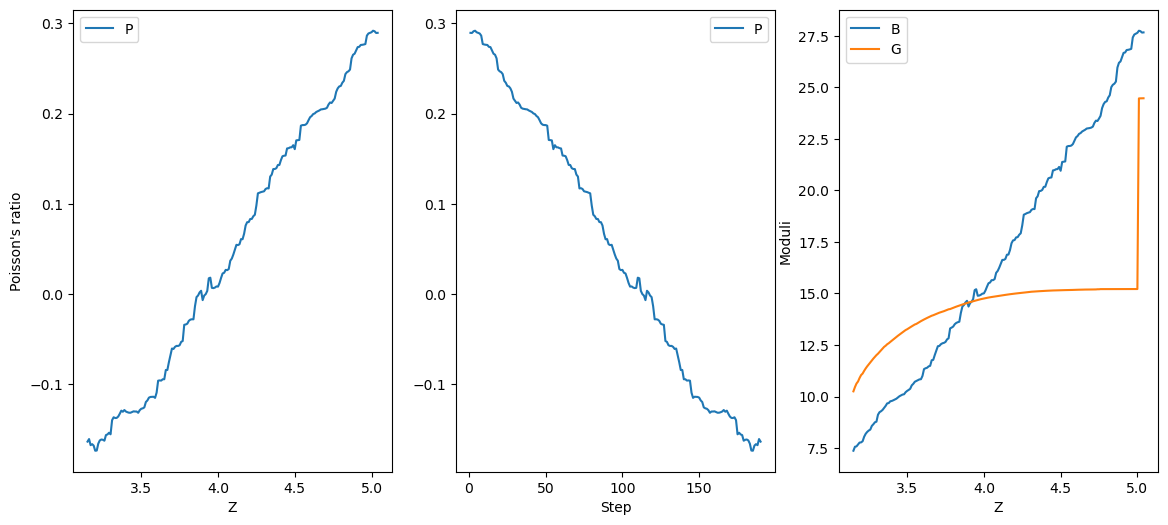

In [4]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))
# P ratio graph
axs[0].plot(Zs, Ps, label='P')
axs[0].set_ylabel("Poisson's ratio")
axs[0].set_xlabel("Z")
# axs[0].set_ylim(-0.15, 0.25)
axs[0].legend()
# P ratio graph
axs[1].plot(steps, Ps, label='P')
axs[1].set_xlabel("Step")
# axs[1].set_ylim(-0.15, 0.25)
axs[1].legend()
# Moduli graph
axs[2].plot(Zs, Bs, label='B')
axs[2].plot(Zs, Gs, label='G')
axs[2].set_ylabel("Moduli")
axs[2].set_xlabel("Z")
axs[2].legend()

plt.show()
